# Actual Clustering

In this notebook we produce clusters for all tasks using two clustering algorithms: `Kruskal MST` and `Affinity Propagation` as described below.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import AffinityPropagation
from IPython.display import Image

### Similarity matrices

For the ease of processing, we serialised similarity matrices we obtained as csv files.

They can be conveniently read as dataframes that consequently serve as an input to functions described below to produce clusters.

In [2]:
pd.read_csv("matrices/reference.csv", index_col="idx")

,S001,S002,S003,S004,S006,S007,S008,S010,S011,S012,...,S363,S365,S367,S369,S370,S371,S372,S373,S374,S376
idx,,,,,,,,,,,,,,,,,,,,,
S001,1.000000,0.343750,0.816667,0.482759,0.564516,0.634921,0.479452,0.449275,0.553846,0.892308,...,0.769231,0.500000,0.545455,0.534247,0.561404,0.465753,0.246575,0.684211,0.700000,0.260274
S002,0.343750,1.000000,0.125000,0.166667,0.406250,0.290323,0.343750,0.343750,0.166667,0.125000,...,0.125000,0.343750,0.125000,0.406250,0.406250,0.375000,0.468750,0.473684,0.125000,0.937500
S003,0.816667,0.125000,1.000000,0.344828,0.444444,0.446429,0.350000,0.283333,0.433333,0.700000,...,0.616667,0.384615,0.409091,0.483333,0.408163,0.350000,0.100000,0.545455,0.650000,0.116667
S004,0.482759,0.166667,0.344828,1.000000,0.592593,0.696429,0.413793,0.310345,0.620690,0.586207,...,0.655172,0.384615,0.409091,0.396552,0.530612,0.448276,0.155172,0.454545,0.293103,0.293103
S006,0.564516,0.406250,0.444444,0.592593,1.000000,0.655738,0.532258,0.483871,0.703704,0.685185,...,0.629630,0.500000,0.477273,0.725806,0.807018,0.548387,0.403226,0.736842,0.351852,0.354839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S371,0.465753,0.375000,0.350000,0.448276,0.548387,0.555556,0.358974,0.579710,0.442857,0.470588,...,0.328571,0.583333,0.363636,0.461538,0.456140,1.000000,0.526316,0.631579,0.400000,0.216216
S372,0.246575,0.468750,0.100000,0.155172,0.403226,0.206349,0.486842,0.652174,0.250000,0.147059,...,0.147059,0.233333,0.454545,0.263158,0.385965,0.526316,1.000000,0.526316,0.150000,0.445946
S373,0.684211,0.473684,0.545455,0.454545,0.736842,0.722222,0.684211,0.473684,0.636364,0.636364,...,0.545455,0.684211,0.272727,0.684211,0.526316,0.631579,0.526316,1.000000,0.545455,0.631579


### Code for Kruskal's Minimal Spanning Tree

Kruskal algorithm takes a connected weighted edge graph and returns Minimal cost Spanning Tree* (picture below).

When a graph is not connected Kruskal returns a forest (a graph with more than one tree) of MSTs.

We use it as a foundation for clustering: each MST can be viewed as a cluster.
Since we are rather interested in what vertex belongs to what component rather that how exactly they are conected (a=b and b=c or a=c and c=b), we can omit MST construction part for optimisation and readability purposes. 

Following this modification, our algorithm basically serves as a disjoint set unification algorithm. 
To denote the origin of the idea for algorithm, we still name it `kruskal`.

*MST or Minimal cost Spanning Tree -- tree connecting all vertices of the weighted edge graph that has the minimal possible weight.

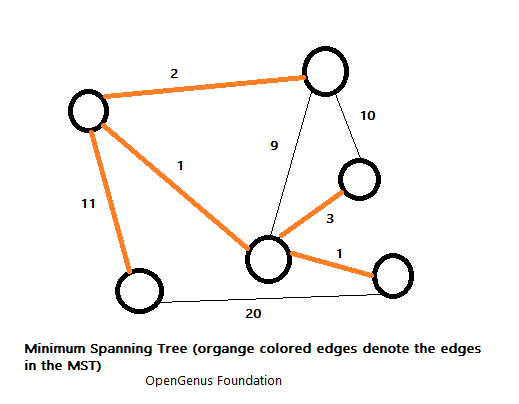

In [3]:
Image('assets/mst.png') #[1]

In [4]:
class Edge():
    """
    Class that represents an edge in a weighted graph
    fields: 
        a, b  - indices in the dataframe corresponding to a vertex
        distance - distance between vertices, (1 - similarity of programs coresponding to indices)
    """
    def __init__(self, a: int, b: int, distance: float) -> None:
        self.a = a
        self.b = b
        self.distance = distance

def kruskal(df: pd.DataFrame, threshold=0.85) -> list[list[str]]:
    """
    Kruskal algorithm takes a graph and returns Minimal cost Spanning Tree for it
    Run Kruskal MST algorithm's part(merging connected components) on the similarity matrix

    params:
        df - similarity matrix
        threshold - if a distance between vertices is above this value we do not add this edge, submissions won't be connected
                    yet they can be connected through other components 
    """
    edges = sorted(createEdges(df, threshold), key=lambda edge : edge.distance)
    #Initially each component is in a cluster of its own
    connected_components = [{i} for i in range(len(df))]

    for edge in edges:
        component_A, component_B = -1, -1
        for i in range(len(connected_components)):
            if edge.a in connected_components[i]:
                component_A = i
            if edge.b in connected_components[i]:
                component_B = i
        if component_A == component_B:
            continue
        #Merge connected components
        connected_components[component_A].update(connected_components.pop(component_B))

    return [[df.index[i] for i in connected_component] for connected_component in connected_components]

def createEdges(df: pd.DataFrame, threshold: float) -> list[Edge]:
    """
    Function creates edges from the given dataframe (distance between programms)
    Only edges that are above threshold are added
    """
    n, _ = df.shape 
    #Formula for distance: distance = 1 - similarity
    #Since distance is reflexive property and we do not need to add loops (edge from vertex to itself) 
    #we can just iterate over triangle of the matrix
    return [Edge(i, j, 1 - df.iloc[i][j]) for i in range(n) for j in range(i+1, n) if df.iloc[i][j] > threshold]


### Code to get clusters of students from Affinity Propagation

Affinitiy propagation can take affinity matrix as a custom distance measure. So, we feed it a similarity matrix that can be viewed as an affinity matrix.

In [5]:
def affinity_Propagation(df: pd.DataFrame) -> list[list[str]]:
    """
        params:
        df -- similarity matrix
    """    
    af = AffinityPropagation(affinity='precomputed', random_state=42)
    af.fit(df)
    cluster_centers = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers)
    clusters=[list() for i in range(len(cluster_centers))]
    for i, cluster in enumerate(labels):
        clusters[cluster].append(df.index[i])
    return clusters

## Clusters

Since we deal with similarities/distances that are abstracted from 2D plane (triangle inequality does not hold), visualisation does not seem reasonable. On top of that, it will be quite hard to read out student labels if they are in the same big cluster. For that reason we are just content with printing student code clusters in a form of a list.

In [6]:
files = [f"matrices/{file_name}" for file_name in sorted(filter(lambda file: file.endswith('.csv'), next(os.walk('matrices'))[2]))]
print(f"Files we work with:\n{files}")

Files we work with:
['matrices/K01_kodu1.csv', 'matrices/K02_kodu2.csv', 'matrices/K02_kodu3.csv', 'matrices/K02_kodu4.csv', 'matrices/K03_kodu1.csv', 'matrices/K03_kodu2.csv', 'matrices/K03_kodu3.csv', 'matrices/K03_kodu4.csv', 'matrices/K04_kodu1.csv', 'matrices/K04_kodu2.csv', 'matrices/K04_kodu3.csv', 'matrices/K05_kodu1.csv', 'matrices/K05_kodu2.csv', 'matrices/K05_kodu3.csv', 'matrices/K07_kodu1.csv', 'matrices/K07_kodu2.csv', 'matrices/K07_kodu3.csv', 'matrices/K08_film.csv', 'matrices/K08_kodu1.csv', 'matrices/K08_kodu3.csv', 'matrices/K09_kodu1.csv', 'matrices/K09_kodu2.csv', 'matrices/K10_kodu1.csv', 'matrices/K10_kodu2.csv', 'matrices/K11_kodu1.csv', 'matrices/K11_kodu2.csv', 'matrices/K13_kodu1.csv', 'matrices/K13_kodu2.csv', 'matrices/K14_kodu1.csv', 'matrices/K14_kodu2.csv', 'matrices/K15_kodu1.csv', 'matrices/K15_kodu2.csv', 'matrices/K15_kodu3.csv', 'matrices/reference.csv']


In [7]:
def printer(clusters):
    i = 0
    for cluster in clusters:
        i += len(cluster)
        end = ' '
        if i > 17:
            end = '\n'
            i = 0
        print(cluster, end=end)

In [8]:
K01_kodu1 = pd.read_csv("matrices/K01_kodu1.csv", index_col="idx")

In [9]:
printer(affinity_Propagation(K01_kodu1))

['S008', 'S019', 'S027', 'S029', 'S077', 'S085', 'S099', 'S126', 'S185', 'S187', 'S189', 'S220', 'S244', 'S297', 'S329', 'S344'] ['S035', 'S040', 'S042', 'S044', 'S087', 'S093', 'S107', 'S109', 'S119', 'S124', 'S130', 'S146', 'S172', 'S219', 'S225', 'S235', 'S245', 'S277', 'S340', 'S341', 'S351', 'S361', 'S364', 'S367']
['S006', 'S041', 'S053', 'S056', 'S062', 'S082', 'S113', 'S127', 'S141', 'S143', 'S160', 'S167', 'S177', 'S184', 'S224', 'S234', 'S249', 'S259', 'S260', 'S270', 'S271', 'S300', 'S306', 'S310', 'S350']
['S001', 'S002', 'S003', 'S004', 'S005', 'S007', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S028', 'S030', 'S031', 'S032', 'S033', 'S034', 'S036', 'S037', 'S038', 'S039', 'S043', 'S045', 'S048', 'S049', 'S050', 'S051', 'S052', 'S054', 'S055', 'S057', 'S058', 'S059', 'S060', 'S061', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S07

In [10]:
printer(kruskal(K01_kodu1))

['S006'] ['S014'] ['S040'] ['S050'] ['S084'] ['S120'] ['S001', 'S002', 'S003', 'S004', 'S005', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S041', 'S042', 'S043', 'S044', 'S045', 'S048', 'S049', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S119', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', '

In [11]:
K02_kodu2 = pd.read_csv("matrices/K02_kodu2.csv", index_col="idx")

In [12]:
printer(affinity_Propagation(K02_kodu2))

['S003', 'S352'] ['S004', 'S007', 'S010', 'S018', 'S032', 'S057', 'S061', 'S063', 'S068', 'S074', 'S079', 'S120', 'S135', 'S159', 'S164', 'S170', 'S174', 'S179', 'S207', 'S212', 'S237', 'S238', 'S239', 'S251', 'S257', 'S261', 'S271', 'S278', 'S279', 'S286', 'S287', 'S289', 'S297', 'S302', 'S309', 'S318', 'S325', 'S372', 'S373', 'S376']
['S013', 'S036', 'S099'] ['S021', 'S304', 'S313'] ['S024', 'S030', 'S039', 'S040', 'S124', 'S167', 'S176', 'S186', 'S229', 'S254'] ['S025', 'S048', 'S121', 'S203', 'S208', 'S259', 'S293', 'S300', 'S328']
['S029', 'S046', 'S236'] ['S041'] ['S043', 'S110'] ['S053', 'S064', 'S268'] ['S075'] ['S077', 'S094', 'S232'] ['S081', 'S085', 'S223'] ['S087', 'S092', 'S114', 'S123', 'S154', 'S168', 'S234', 'S262', 'S345']
['S095'] ['S019', 'S038', 'S067', 'S100', 'S169', 'S260', 'S368'] ['S005', 'S017', 'S037', 'S044', 'S052', 'S060', 'S062', 'S065', 'S070', 'S080', 'S106', 'S117', 'S118', 'S137', 'S157', 'S163', 'S172', 'S199', 'S213', 'S218', 'S221', 'S240', 'S272',

c:\Python310\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [13]:
printer(kruskal(K02_kodu2))

['S015'] ['S001', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S043', 'S045', 'S046', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S058', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S096', 'S097', 'S098', 'S099', 'S100', 'S103', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S132', 'S135', 'S136', 'S138', 'S141', 'S144', 'S145', 'S148', 'S149', 'S151', 'S152', 'S153', 'S154', 'S155', 'S156'

In [14]:
K02_kodu3 = pd.read_csv("matrices/K02_kodu3.csv", index_col="idx")

In [15]:
printer(affinity_Propagation(K02_kodu3))

['S012'] ['S014', 'S042', 'S050'] ['S001', 'S003', 'S005', 'S013', 'S015', 'S026', 'S030', 'S034', 'S043', 'S044', 'S049', 'S065', 'S079', 'S086', 'S089', 'S091', 'S099', 'S102', 'S106', 'S114', 'S136', 'S137', 'S155', 'S160', 'S164', 'S183', 'S184', 'S187', 'S190', 'S193', 'S195', 'S201', 'S220', 'S221', 'S222', 'S234', 'S244', 'S253', 'S256', 'S262', 'S263', 'S265', 'S284', 'S296', 'S328', 'S331', 'S333', 'S341', 'S349']
['S016', 'S032', 'S062', 'S063', 'S088', 'S119', 'S120', 'S172', 'S217', 'S228', 'S236', 'S237', 'S251', 'S286', 'S299', 'S315', 'S329', 'S332', 'S363']
['S033', 'S124', 'S170', 'S241', 'S326', 'S330'] ['S006', 'S017', 'S020', 'S021', 'S023', 'S024', 'S031', 'S035', 'S036', 'S037', 'S040', 'S051', 'S052', 'S056', 'S057', 'S058', 'S060', 'S064', 'S067', 'S068', 'S069', 'S071', 'S075', 'S080', 'S081', 'S083', 'S087', 'S092', 'S098', 'S101', 'S103', 'S105', 'S108', 'S109', 'S110', 'S115', 'S117', 'S121', 'S122', 'S123', 'S125', 'S133', 'S140', 'S141', 'S142', 'S143', 'S

c:\Python310\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [16]:
printer(kruskal(K02_kodu3))

['S001', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S057', 'S058', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S131',

In [17]:
K02_kodu4 = pd.read_csv("matrices/K02_kodu4.csv", index_col="idx")

In [18]:
printer(affinity_Propagation(K02_kodu4))

['S042'] ['S045'] ['S006', 'S018', 'S019', 'S023', 'S036', 'S043', 'S044', 'S064', 'S065', 'S066', 'S067', 'S096', 'S098', 'S120', 'S128', 'S131', 'S142', 'S144', 'S168', 'S191', 'S198', 'S204', 'S210', 'S215', 'S224', 'S289', 'S309', 'S371']
['S005', 'S015', 'S072'] ['S007', 'S009', 'S020', 'S035', 'S079', 'S084', 'S093', 'S102', 'S135', 'S145', 'S148', 'S152', 'S162', 'S171', 'S172', 'S181', 'S182', 'S184', 'S189', 'S197', 'S218', 'S248', 'S258', 'S274', 'S283', 'S288', 'S306', 'S314', 'S315', 'S320', 'S346']
['S008', 'S013', 'S014', 'S030', 'S034', 'S052', 'S053', 'S085', 'S090', 'S109', 'S110', 'S111', 'S114', 'S117', 'S119', 'S125', 'S129', 'S136', 'S138', 'S159', 'S175', 'S176', 'S186', 'S202', 'S205', 'S229', 'S237', 'S244', 'S249', 'S251', 'S262', 'S267', 'S270', 'S275', 'S285', 'S298', 'S302', 'S313', 'S324', 'S328', 'S334', 'S355', 'S356', 'S370', 'S373', 'S374', 'S375']
['S143'] ['S194', 'S206', 'S303'] ['S012', 'S016', 'S025', 'S029', 'S039', 'S041', 'S048', 'S049', 'S058',

In [19]:
printer(kruskal(K02_kodu4))

['S005'] ['S015'] ['S042'] ['S045'] ['S143'] ['S144'] ['S001', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S043', 'S044', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S057', 'S058', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S127', 'S128', 'S129', '

In [20]:
K03_kodu1 = pd.read_csv("matrices/K03_kodu1.csv", index_col="idx")

In [21]:
printer(affinity_Propagation(K03_kodu1))

['S003', 'S019', 'S025', 'S078', 'S079', 'S095', 'S123', 'S132', 'S170', 'S176', 'S239', 'S243', 'S292', 'S330', 'S341'] ['S023', 'S048', 'S067', 'S107', 'S137', 'S164', 'S201', 'S224', 'S260', 'S373']
['S081', 'S191', 'S301', 'S320', 'S328', 'S329'] ['S011', 'S087', 'S122', 'S219', 'S242'] ['S021', 'S034', 'S069', 'S103', 'S105', 'S140', 'S213', 'S318', 'S337']
['S010', 'S014', 'S043', 'S121', 'S141', 'S190', 'S205', 'S313', 'S335', 'S372'] ['S084', 'S168', 'S370'] ['S007', 'S035', 'S093', 'S126', 'S145', 'S147', 'S177', 'S186', 'S202', 'S221', 'S256', 'S263', 'S289', 'S309', 'S347', 'S357']
['S098', 'S130', 'S155', 'S211', 'S231', 'S251', 'S283', 'S286', 'S296', 'S297', 'S367'] ['S022', 'S073', 'S112', 'S124', 'S162', 'S196', 'S217', 'S376']
['S001', 'S009', 'S016', 'S017', 'S018', 'S020', 'S027', 'S029', 'S030', 'S032', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S045', 'S047', 'S050', 'S051', 'S053', 'S055', 'S056', 'S058', 'S060', 'S061', 'S063', 'S070', 'S071', 'S072', 'S082

In [22]:
printer(kruskal(K03_kodu1))

['S006'] ['S009'] ['S010'] ['S292', 'S003', 'S079', 'S078', 'S011', 'S087', 'S019', 'S095', 'S239', 'S170', 'S242', 'S025', 'S243', 'S176', 'S330', 'S122', 'S123', 'S219']
['S012', 'S356', 'S343', 'S008'] ['S001', 'S004', 'S013', 'S014', 'S016', 'S017', 'S018', 'S020', 'S027', 'S029', 'S030', 'S032', 'S033', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S043', 'S044', 'S045', 'S046', 'S049', 'S050', 'S051', 'S053', 'S055', 'S056', 'S058', 'S060', 'S061', 'S063', 'S064', 'S065', 'S068', 'S071', 'S072', 'S074', 'S075', 'S080', 'S082', 'S084', 'S085', 'S088', 'S090', 'S091', 'S094', 'S096', 'S098', 'S099', 'S100', 'S101', 'S102', 'S106', 'S108', 'S110', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S120', 'S121', 'S125', 'S127', 'S128', 'S130', 'S134', 'S138', 'S139', 'S141', 'S143', 'S148', 'S152', 'S153', 'S155', 'S158', 'S160', 'S165', 'S166', 'S168', 'S169', 'S171', 'S172', 'S174', 'S175', 'S179', 'S180', 'S182', 'S183', 'S184', 'S185', 'S187', 'S188', 'S189', 'S190', 'S192', 'S

In [23]:
K03_kodu2 = pd.read_csv("matrices/K03_kodu2.csv", index_col="idx")

In [24]:
printer(affinity_Propagation(K03_kodu2))

['S016'] ['S014', 'S019', 'S027', 'S034', 'S037', 'S038', 'S041', 'S044', 'S052', 'S053', 'S063', 'S067', 'S073', 'S077', 'S100', 'S116', 'S119', 'S120', 'S121', 'S125', 'S127', 'S128', 'S153', 'S163', 'S164', 'S165', 'S168', 'S174', 'S195', 'S197', 'S203', 'S219', 'S247', 'S248', 'S249', 'S257', 'S272', 'S277', 'S280', 'S286', 'S287', 'S293', 'S318', 'S325', 'S328', 'S330', 'S331', 'S333', 'S335', 'S342', 'S344', 'S367', 'S370', 'S373']
['S011', 'S021', 'S026', 'S030', 'S051', 'S080', 'S099', 'S106', 'S112', 'S113', 'S130', 'S148', 'S155', 'S166', 'S177', 'S202', 'S208', 'S224', 'S233', 'S238', 'S243', 'S288', 'S299', 'S313', 'S377']
['S002', 'S023', 'S045', 'S046', 'S049', 'S065', 'S070', 'S086', 'S093', 'S118', 'S169', 'S179', 'S212', 'S228', 'S266', 'S275', 'S311', 'S320', 'S322', 'S347', 'S351', 'S364']
['S048', 'S255', 'S258', 'S271', 'S354'] ['S010', 'S036', 'S040', 'S050', 'S061', 'S079', 'S126', 'S171', 'S173', 'S182', 'S187', 'S191', 'S192', 'S207', 'S210', 'S211', 'S218', 'S

c:\Python310\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [25]:
printer(kruskal(K03_kodu2))

['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S013', 'S014', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S029', 'S030', 'S032', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S061', 'S063', 'S064', 'S065', 'S068', 'S069', 'S070', 'S072', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090', 'S091', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S122', 'S123', 'S124', 'S126', 'S127', 'S130', 'S132', 'S134', 'S136', 'S137', 'S138', 'S139', 'S140', 'S141', 'S143', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153', 'S155', 'S158', 'S162', 'S164', 'S166', 'S167', 'S168', 'S169', 'S170',

In [26]:
K03_kodu3 = pd.read_csv("matrices/K03_kodu3.csv", index_col="idx")

In [27]:
printer(affinity_Propagation(K03_kodu3))

['S001', 'S002', 'S003', 'S004', 'S007', 'S008', 'S009', 'S010', 'S011', 'S013', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S023', 'S027', 'S030', 'S032', 'S033', 'S035', 'S036', 'S037', 'S040', 'S044', 'S045', 'S046', 'S048', 'S049', 'S050', 'S051', 'S053', 'S055', 'S056', 'S060', 'S061', 'S064', 'S065', 'S067', 'S068', 'S071', 'S072', 'S073', 'S074', 'S075', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S086', 'S087', 'S090', 'S091', 'S094', 'S097', 'S098', 'S099', 'S101', 'S102', 'S103', 'S106', 'S107', 'S108', 'S109', 'S110', 'S112', 'S113', 'S114', 'S115', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S130', 'S133', 'S134', 'S135', 'S137', 'S138', 'S139', 'S141', 'S143', 'S144', 'S145', 'S147', 'S148', 'S151', 'S152', 'S153', 'S158', 'S160', 'S163', 'S164', 'S165', 'S167', 'S169', 'S171', 'S172', 'S174', 'S176', 'S177', 'S178', 'S180', 'S181', 'S182', 'S183', 'S184', 'S186', 'S187', 'S188', 'S191', 'S192', 'S193', 'S194', 'S195',

In [28]:
printer(kruskal(K03_kodu3))

['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S026', 'S027', 'S030', 'S032', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S044', 'S045', 'S046', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S068', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S087', 'S090', 'S091', 'S093', 'S094', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S112', 'S113', 'S114', 'S115', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S130', 'S133', 'S134', 'S135', 'S137', 'S138', 'S139', 'S140', 'S141', 'S143', 'S144', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153', 'S155', 'S158', 'S160', 'S162', 'S163', 'S164', 'S165', 'S167', 'S169', 'S170',

In [29]:
K03_kodu4 = pd.read_csv("matrices/K03_kodu4.csv", index_col="idx")

In [30]:
printer(affinity_Propagation(K03_kodu4))

['S008', 'S032', 'S046', 'S068', 'S081', 'S105', 'S145', 'S151', 'S166', 'S178', 'S189', 'S214', 'S228', 'S238', 'S342', 'S343', 'S374'] ['S022', 'S025', 'S060', 'S094', 'S110', 'S113', 'S180', 'S203', 'S242', 'S317', 'S376']
['S010', 'S043', 'S051', 'S052', 'S082', 'S117', 'S139', 'S199', 'S213', 'S216', 'S244', 'S315', 'S344', 'S345', 'S352', 'S363'] ['S072', 'S084', 'S144', 'S206', 'S212', 'S303', 'S309', 'S357', 'S364']
['S002', 'S045', 'S077', 'S090', 'S100', 'S171', 'S187', 'S210', 'S227', 'S233', 'S234', 'S240', 'S260', 'S282', 'S283', 'S289', 'S314', 'S322', 'S327', 'S338', 'S347', 'S358']
['S004', 'S013', 'S023', 'S083', 'S168', 'S239', 'S241', 'S256', 'S269', 'S330'] ['S001', 'S003', 'S006', 'S007', 'S009', 'S011', 'S012', 'S014', 'S016', 'S017', 'S020', 'S026', 'S030', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S044', 'S047', 'S048', 'S049', 'S050', 'S053', 'S055', 'S056', 'S061', 'S063', 'S064', 'S067', 'S069', 'S070', 'S071', 'S073', 'S075', 'S078', 'S079', '

In [31]:
printer(kruskal(K03_kodu4))

['S018'] ['S043'] ['S121'] ['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S016', 'S017', 'S020', 'S021', 'S022', 'S023', 'S025', 'S026', 'S027', 'S030', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S088', 'S090', 'S091', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S123', 'S124', 'S125', 'S126', 'S128', 'S130', 'S132', 'S133', 'S134', 'S135', 'S137', 'S139', 'S140', 'S141', 'S143', 'S144', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153', 'S155', 'S15

In [32]:
K04_kodu1 = pd.read_csv("matrices/K04_kodu1.csv", index_col="idx")

In [33]:
printer(affinity_Propagation(K04_kodu1))

['S019', 'S032', 'S057', 'S071', 'S084', 'S092', 'S099', 'S124', 'S128', 'S147', 'S163', 'S178', 'S180', 'S181', 'S242', 'S266', 'S272', 'S305', 'S308', 'S334', 'S337']
['S007', 'S043', 'S073', 'S090', 'S097', 'S119', 'S141', 'S169', 'S207', 'S218', 'S230', 'S243', 'S249', 'S251', 'S260', 'S273', 'S347', 'S365', 'S370', 'S373', 'S376']
['S008', 'S046', 'S081', 'S111', 'S158', 'S162', 'S244', 'S293', 'S307', 'S309', 'S324', 'S328', 'S357'] ['S051', 'S100', 'S165', 'S166', 'S187', 'S257']
['S063', 'S069', 'S126', 'S133', 'S153', 'S287', 'S317', 'S355'] ['S010', 'S036', 'S055', 'S060', 'S068', 'S072', 'S132', 'S175'] ['S035', 'S079', 'S082', 'S106']
['S006', 'S013', 'S017', 'S034', 'S044', 'S047', 'S061', 'S083', 'S085', 'S103', 'S107', 'S108', 'S110', 'S112', 'S113', 'S115', 'S117', 'S118', 'S123', 'S125', 'S129', 'S137', 'S148', 'S151', 'S164', 'S177', 'S190', 'S192', 'S193', 'S194', 'S195', 'S204', 'S205', 'S206', 'S210', 'S214', 'S232', 'S234', 'S238', 'S239', 'S246', 'S263', 'S265', 

In [34]:
printer(kruskal(K04_kodu1))

['S007'] ['S008'] ['S010'] ['S013'] ['S019'] ['S025'] ['S026'] ['S030'] ['S033'] ['S034'] ['S035'] ['S036'] ['S037'] ['S038'] ['S040'] ['S044'] ['S045'] ['S047']
['S052'] ['S055'] ['S057'] ['S060'] ['S063'] ['S064'] ['S065'] ['S067'] ['S068'] ['S069'] ['S070'] ['S312', 'S071'] ['S072'] ['S073'] ['S075'] ['S079'] ['S082']
['S084'] ['S088'] ['S094'] ['S095'] ['S097'] ['S098'] ['S102'] ['S104'] ['S106'] ['S113'] ['S126'] ['S132'] ['S133'] ['S137'] ['S138'] ['S141'] ['S145'] ['S147']
['S149'] ['S153'] ['S154'] ['S157'] ['S158'] ['S160', 'S320'] ['S161'] ['S163'] ['S167'] ['S168'] ['S172'] ['S175'] ['S187'] ['S189'] ['S190'] ['S191'] ['S195']
['S199'] ['S201'] ['S203'] ['S211'] ['S212'] ['S213'] ['S219'] ['S222'] ['S225'] ['S227'] ['S230'] ['S231'] ['S234'] ['S001', 'S002', 'S003', 'S004', 'S006', 'S009', 'S011', 'S017', 'S018', 'S021', 'S022', 'S023', 'S024', 'S027', 'S032', 'S039', 'S046', 'S049', 'S050', 'S051', 'S053', 'S056', 'S061', 'S074', 'S077', 'S078', 'S080', 'S081', 'S083', 'S08

In [35]:
K04_kodu2 = pd.read_csv("matrices/K04_kodu2.csv", index_col="idx")

In [36]:
printer(affinity_Propagation(K04_kodu2))

['S003', 'S025', 'S043', 'S045', 'S050', 'S077', 'S135', 'S140', 'S166', 'S176', 'S188', 'S247', 'S267', 'S279', 'S344'] ['S009'] ['S017'] ['S001', 'S018', 'S022', 'S051', 'S053', 'S169', 'S172', 'S228', 'S238', 'S266', 'S328', 'S334', 'S374']
['S023', 'S030', 'S065', 'S093', 'S105', 'S143', 'S161', 'S178', 'S236', 'S245', 'S259', 'S318', 'S329', 'S351'] ['S002', 'S036', 'S046', 'S048', 'S072', 'S086', 'S101', 'S112', 'S116', 'S117', 'S129', 'S141', 'S149', 'S173', 'S177', 'S179', 'S191', 'S197', 'S206', 'S211', 'S224', 'S239', 'S250', 'S269', 'S271', 'S272', 'S273', 'S296', 'S309', 'S311', 'S320', 'S340', 'S348', 'S352', 'S369', 'S371']
['S037', 'S060', 'S082', 'S096', 'S163', 'S210', 'S227', 'S256', 'S258', 'S291', 'S335', 'S356'] ['S049'] ['S063'] ['S073'] ['S074', 'S083', 'S111', 'S190', 'S287', 'S317']
['S084'] ['S024', 'S069', 'S085', 'S103', 'S107', 'S115', 'S148', 'S158', 'S162', 'S171', 'S180', 'S182', 'S195', 'S214', 'S230', 'S233', 'S241', 'S246', 'S288', 'S289', 'S299', 'S3

c:\Python310\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [37]:
printer(kruskal(K04_kodu2))

['S009'] ['S017'] ['S049'] ['S063'] ['S073'] ['S084'] ['S091'] ['S092'] ['S095'] ['S102'] ['S133'] ['S143'] ['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S010', 'S011', 'S013', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S030', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S043', 'S045', 'S046', 'S047', 'S048', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S057', 'S058', 'S060', 'S061', 'S064', 'S065', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S086', 'S087', 'S088', 'S090', 'S093', 'S094', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S123', 'S124', 'S125', 'S126', 'S128', 'S129', 'S130', 'S132', 'S134', 'S135', 'S137', 'S138', 'S140', 'S141', 'S145', 'S147', 'S148', 'S149', 'S151', 'S153', 'S1

In [38]:
K04_kodu3 = pd.read_csv("matrices/K04_kodu3.csv", index_col="idx")

In [39]:
printer(affinity_Propagation(K04_kodu3))

['S104'] ['S046', 'S111', 'S129', 'S195', 'S210', 'S315', 'S364'] ['S138'] ['S002', 'S030', 'S036', 'S049', 'S064', 'S065', 'S068', 'S071', 'S086', 'S088', 'S095', 'S113', 'S128', 'S132', 'S145', 'S147', 'S162', 'S177', 'S213', 'S219', 'S220', 'S222', 'S223', 'S233', 'S234', 'S245', 'S255', 'S259', 'S260', 'S293', 'S357']
['S009', 'S023', 'S026', 'S110', 'S112', 'S134', 'S168', 'S170', 'S188', 'S189', 'S202', 'S277', 'S289', 'S299', 'S344', 'S347'] ['S018', 'S022', 'S060', 'S061', 'S083', 'S085', 'S101', 'S105', 'S108', 'S126', 'S160', 'S161', 'S171', 'S190', 'S200', 'S201', 'S216', 'S244', 'S246', 'S267', 'S278', 'S288', 'S305', 'S318', 'S346', 'S349', 'S370', 'S373']
['S001', 'S004', 'S007', 'S013', 'S021', 'S034', 'S037', 'S040', 'S043', 'S045', 'S050', 'S053', 'S057', 'S063', 'S067', 'S073', 'S079', 'S081', 'S096', 'S098', 'S100', 'S106', 'S114', 'S116', 'S117', 'S119', 'S120', 'S123', 'S133', 'S137', 'S143', 'S148', 'S151', 'S152', 'S155', 'S158', 'S163', 'S166', 'S173', 'S175', '

In [40]:
printer(kruskal(K04_kodu3))

['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S010', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S026', 'S030', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S039', 'S040', 'S043', 'S045', 'S046', 'S047', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S057', 'S058', 'S060', 'S061', 'S063', 'S064', 'S067', 'S069', 'S070', 'S071', 'S072', 'S073', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S088', 'S090', 'S091', 'S092', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S106', 'S107', 'S108', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S123', 'S124', 'S125', 'S126', 'S128', 'S129', 'S130', 'S132', 'S133', 'S134', 'S137', 'S140', 'S141', 'S143', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S154', 'S155', 'S158', 'S160', 'S161', 'S162', 'S163', 'S164', 'S165', 'S166', 'S167', 'S168', 'S169', 'S170',

In [41]:
K05_kodu1 = pd.read_csv("matrices/K05_kodu1.csv", index_col="idx")

In [42]:
printer(affinity_Propagation(K05_kodu1))

['S004', 'S052', 'S053', 'S068', 'S082', 'S103', 'S105', 'S110', 'S141', 'S144', 'S163', 'S164', 'S181', 'S204', 'S216', 'S249', 'S255', 'S272', 'S278', 'S286', 'S289', 'S299', 'S309', 'S312', 'S346', 'S350']
['S018', 'S023', 'S046', 'S072', 'S085', 'S093', 'S095', 'S099', 'S139', 'S147', 'S154', 'S155', 'S168', 'S186', 'S191', 'S242', 'S243', 'S253', 'S258', 'S264', 'S279', 'S300', 'S303', 'S307', 'S322', 'S327', 'S340', 'S348', 'S352', 'S359', 'S374', 'S376']
['S010', 'S027', 'S030', 'S037', 'S045', 'S074', 'S075', 'S081', 'S086', 'S113', 'S117', 'S133', 'S138', 'S149', 'S157', 'S160', 'S167', 'S179', 'S183', 'S184', 'S188', 'S190', 'S206', 'S227', 'S232', 'S245', 'S252', 'S271', 'S311', 'S313', 'S316', 'S323', 'S341', 'S354', 'S357', 'S362', 'S364']
['S007', 'S012', 'S038', 'S088', 'S102', 'S125', 'S127', 'S140', 'S148', 'S165', 'S189', 'S196', 'S197', 'S233', 'S274', 'S304', 'S314', 'S325', 'S335', 'S355']
['S008', 'S021', 'S025', 'S051', 'S060', 'S089', 'S116', 'S118', 'S137', 'S1

c:\Python310\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [43]:
printer(kruskal(K05_kodu1))

['S004'] ['S014'] ['S024'] ['S026'] ['S371', 'S034'] ['S036'] ['S037'] ['S045'] ['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S025', 'S027', 'S029', 'S030', 'S032', 'S033', 'S035', 'S038', 'S039', 'S040', 'S041', 'S043', 'S044', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S056', 'S057', 'S060', 'S061', 'S063', 'S064', 'S067', 'S069', 'S070', 'S071', 'S072', 'S074', 'S075', 'S077', 'S078', 'S081', 'S083', 'S085', 'S086', 'S088', 'S089', 'S091', 'S093', 'S096', 'S097', 'S099', 'S100', 'S102', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S112', 'S113', 'S115', 'S116', 'S117', 'S118', 'S119', 'S121', 'S122', 'S123', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S132', 'S133', 'S135', 'S139', 'S140', 'S141', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153', 'S154', 'S155', 'S158', 'S160', 'S163', 'S165', 'S167', 'S168', 'S169', 'S170', 'S172', 'S173', 'S174', 'S175', 'S176', 'S177', 'S178',

In [44]:
K05_kodu2 = pd.read_csv("matrices/K05_kodu2.csv", index_col="idx")

In [45]:
printer(affinity_Propagation(K05_kodu2))

['S011', 'S013', 'S014', 'S096', 'S114', 'S157', 'S162', 'S166', 'S190', 'S194', 'S254', 'S296', 'S298', 'S300'] ['S019', 'S374'] ['S048', 'S094', 'S104', 'S241', 'S295', 'S341', 'S350']
['S004', 'S036', 'S067', 'S072', 'S092', 'S109', 'S117', 'S127', 'S161', 'S176', 'S222', 'S223', 'S250', 'S252', 'S276', 'S287', 'S302', 'S346', 'S356', 'S371']
['S160'] ['S021', 'S065', 'S123', 'S164', 'S180', 'S184', 'S203', 'S209', 'S229', 'S260', 'S264', 'S274', 'S286', 'S311', 'S339', 'S340', 'S355']
['S030', 'S049', 'S052', 'S074', 'S095', 'S106', 'S126', 'S153', 'S204', 'S245', 'S272', 'S304'] ['S050', 'S139', 'S247', 'S259', 'S280', 'S307']
['S313'] ['S001', 'S002', 'S003', 'S007', 'S008', 'S009', 'S012', 'S017', 'S018', 'S022', 'S023', 'S024', 'S025', 'S027', 'S032', 'S034', 'S035', 'S037', 'S039', 'S044', 'S045', 'S046', 'S047', 'S053', 'S056', 'S060', 'S061', 'S063', 'S068', 'S069', 'S070', 'S071', 'S073', 'S075', 'S079', 'S080', 'S081', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090'

In [46]:
printer(kruskal(K05_kodu2))

['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S027', 'S029', 'S030', 'S032', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S063', 'S065', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S089', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S132', 'S133', 'S135', 'S137', 'S138', 'S139', 'S140', 'S141', 'S143', 'S144', 'S145', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153',

In [47]:
K05_kodu3 = pd.read_csv("matrices/K05_kodu3.csv", index_col="idx")

In [48]:
printer(affinity_Propagation(K05_kodu3))

['S002', 'S004', 'S045', 'S094', 'S120', 'S176', 'S220', 'S292', 'S364'] ['S014', 'S021', 'S024', 'S025', 'S036', 'S080', 'S119', 'S143', 'S168', 'S170', 'S182', 'S189', 'S236', 'S272', 'S293', 'S295', 'S296', 'S310', 'S362']
['S022', 'S039', 'S040', 'S052', 'S057', 'S063', 'S067', 'S069', 'S082', 'S133', 'S141', 'S144', 'S145', 'S147', 'S205', 'S207', 'S210', 'S223', 'S234', 'S258', 'S259', 'S260', 'S273', 'S298', 'S354', 'S367']
['S041'] ['S008', 'S013', 'S038', 'S043', 'S048', 'S049', 'S083', 'S095', 'S107', 'S111', 'S112', 'S116', 'S123', 'S125', 'S126', 'S128', 'S157', 'S158', 'S164', 'S171', 'S177', 'S178', 'S180', 'S184', 'S193', 'S201', 'S203', 'S204', 'S216', 'S218', 'S224', 'S225', 'S228', 'S229', 'S254', 'S256', 'S261', 'S264', 'S283', 'S287', 'S288', 'S304', 'S308', 'S311', 'S313', 'S329', 'S334', 'S355', 'S357', 'S373']
['S065', 'S271', 'S371'] ['S087'] ['S061', 'S072', 'S092', 'S102', 'S208', 'S248'] ['S103', 'S109', 'S134', 'S139', 'S152', 'S199', 'S211', 'S222', 'S232',

In [49]:
printer(kruskal(K05_kodu3))

['S001'] ['S002'] ['S003'] ['S004'] ['S006'] ['S007'] ['S010'] ['S011'] ['S012'] ['S017'] ['S018'] ['S374', 'S019'] ['S021'] ['S022'] ['S023'] ['S025'] ['S027']
['S030'] ['S343', 'S033'] ['S034'] ['S036'] ['S039'] ['S040', 'S144'] ['S041'] ['S044'] ['S045'] ['S046', 'S081'] ['S047'] ['S050'] ['S051'] ['S052'] ['S313', 'S314', 'S316', 'S008', 'S320', 'S323', 'S013', 'S014', 'S324', 'S327', 'S329', 'S330', 'S024', 'S335', 'S032', 'S035', 'S037', 'S038', 'S346', 'S348', 'S043', 'S350', 'S048', 'S049', 'S355', 'S357', 'S053', 'S363', 'S364', 'S365', 'S370', 'S372', 'S068', 'S373', 'S375', 'S376', 'S078', 'S083', 'S091', 'S093', 'S095', 'S099', 'S101', 'S103', 'S106', 'S107', 'S108', 'S110', 'S111', 'S112', 'S116', 'S117', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S134', 'S137', 'S157', 'S158', 'S160', 'S162', 'S164', 'S165', 'S166', 'S171', 'S173', 'S177', 'S178', 'S179', 'S180', 'S184', 'S186', 'S189', 'S191', 'S193', 'S195', 'S200', 'S201', 'S203', 'S204', 'S206', 'S212', 

In [50]:
K07_kodu1 = pd.read_csv("matrices/K07_kodu1.csv", index_col="idx")

In [51]:
printer(affinity_Propagation(K07_kodu1))

['S002'] ['S003', 'S043', 'S069'] ['S001', 'S006', 'S012', 'S045', 'S057', 'S095', 'S101', 'S111', 'S120', 'S128', 'S129', 'S140', 'S161', 'S168', 'S179', 'S187', 'S191', 'S194', 'S200', 'S222', 'S233', 'S248', 'S256', 'S271', 'S287', 'S309', 'S315', 'S345', 'S356', 'S377']
['S046', 'S051', 'S072', 'S074', 'S075', 'S100', 'S121', 'S132', 'S144', 'S169', 'S182', 'S208', 'S212', 'S230', 'S241', 'S253', 'S257', 'S258', 'S280', 'S291', 'S292', 'S300', 'S302', 'S325', 'S328', 'S351', 'S367', 'S369', 'S372', 'S374']
['S025', 'S048', 'S056', 'S105', 'S247', 'S365'] ['S089', 'S098', 'S164', 'S167'] ['S050', 'S065', 'S067', 'S070', 'S090', 'S110', 'S123', 'S207', 'S277', 'S283', 'S363', 'S371']
['S093', 'S107', 'S134', 'S210', 'S252', 'S275', 'S350'] ['S143'] ['S088', 'S097', 'S138', 'S148', 'S213', 'S235', 'S266', 'S295', 'S326', 'S329']
['S007', 'S115', 'S154', 'S203', 'S211', 'S225', 'S226', 'S264', 'S330', 'S342', 'S376'] ['S023', 'S035', 'S052', 'S137', 'S160', 'S174', 'S177', 'S178', 'S22

In [52]:
printer(kruskal(K07_kodu1))

['S043', 'S003'] ['S016'] ['S023'] ['S053'] ['S069'] ['S080'] ['S098', 'S345', 'S164', 'S089'] ['S095'] ['S001', 'S002', 'S004', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S013', 'S014', 'S017', 'S018', 'S019', 'S021', 'S022', 'S024', 'S025', 'S026', 'S027', 'S030', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S055', 'S056', 'S057', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S068', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S088', 'S090', 'S091', 'S092', 'S093', 'S094', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S107', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S132', 'S134', 'S135', 'S138', 'S139', 'S140', 'S141', 'S144', 'S147', 'S148', 'S149', 'S152',

In [53]:
K07_kodu2 = pd.read_csv("matrices/K07_kodu2.csv", index_col="idx")

In [54]:
printer(affinity_Propagation(K07_kodu2))

['S004', 'S007', 'S012', 'S017', 'S022', 'S040', 'S043', 'S052', 'S055', 'S065', 'S071', 'S102', 'S118', 'S128', 'S134', 'S140', 'S144', 'S155', 'S160', 'S172', 'S181', 'S184', 'S200', 'S220', 'S221', 'S223', 'S224', 'S226', 'S229', 'S233', 'S234', 'S239', 'S247', 'S287', 'S289', 'S295', 'S297', 'S299', 'S302', 'S327', 'S328', 'S329', 'S339', 'S365', 'S370', 'S371', 'S373', 'S377']
['S006', 'S011', 'S018', 'S023', 'S038', 'S061', 'S069', 'S082', 'S083', 'S095', 'S100', 'S101', 'S103', 'S119', 'S121', 'S129', 'S137', 'S156', 'S167', 'S201', 'S206', 'S208', 'S218', 'S219', 'S222', 'S255', 'S257', 'S259', 'S271', 'S288', 'S301', 'S305', 'S337', 'S352', 'S363']
['S030'] ['S001', 'S035', 'S036', 'S063', 'S067', 'S070', 'S073', 'S081', 'S084', 'S091', 'S092', 'S093', 'S099', 'S147', 'S154', 'S161', 'S192', 'S235', 'S261', 'S269', 'S286', 'S292', 'S307', 'S308', 'S309', 'S325', 'S326', 'S349', 'S351', 'S357']
['S074'] ['S089'] ['S098'] ['S013', 'S014', 'S016', 'S019', 'S021', 'S024', 'S025', 

In [55]:
printer(kruskal(K07_kodu2))

['S006'] ['S018'] ['S030'] ['S046'] ['S061'] ['S069'] ['S074'] ['S288', 'S083'] ['S086'] ['S089'] ['S094'] ['S095'] ['S098'] ['S100'] ['S101'] ['S103'] ['S105']
['S119'] ['S129'] ['S143'] ['S156'] ['S168'] ['S169'] ['S171'] ['S201'] ['S206'] ['S208'] ['S210'] ['S218'] ['S001', 'S002', 'S003', 'S004', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S016', 'S017', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S043', 'S045', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S057', 'S060', 'S063', 'S064', 'S065', 'S067', 'S068', 'S070', 'S071', 'S072', 'S073', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S084', 'S085', 'S088', 'S090', 'S091', 'S092', 'S093', 'S096', 'S097', 'S099', 'S102', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S128', 'S130', 'S132', 'S

In [56]:
K07_kodu3 = pd.read_csv("matrices/K07_kodu3.csv", index_col="idx")

In [57]:
printer(affinity_Propagation(K07_kodu3))

['S003', 'S018', 'S043', 'S055', 'S090', 'S118', 'S140', 'S166', 'S191', 'S194', 'S219', 'S234', 'S287', 'S302', 'S316', 'S343'] ['S027', 'S040', 'S047', 'S053', 'S056', 'S068', 'S078', 'S086', 'S099', 'S132', 'S161', 'S183', 'S200', 'S246', 'S274', 'S339']
['S004', 'S007', 'S008', 'S009', 'S010', 'S011', 'S013', 'S016', 'S021', 'S022', 'S023', 'S024', 'S026', 'S032', 'S033', 'S034', 'S036', 'S038', 'S039', 'S046', 'S048', 'S052', 'S064', 'S065', 'S067', 'S070', 'S071', 'S081', 'S082', 'S083', 'S084', 'S091', 'S092', 'S094', 'S096', 'S098', 'S107', 'S111', 'S112', 'S114', 'S115', 'S116', 'S120', 'S121', 'S125', 'S126', 'S127', 'S128', 'S129', 'S137', 'S138', 'S139', 'S144', 'S147', 'S155', 'S158', 'S160', 'S163', 'S164', 'S170', 'S173', 'S176', 'S184', 'S187', 'S192', 'S199', 'S204', 'S206', 'S210', 'S213', 'S220', 'S221', 'S222', 'S224', 'S227', 'S228', 'S229', 'S232', 'S238', 'S244', 'S251', 'S252', 'S253', 'S254', 'S255', 'S258', 'S260', 'S261', 'S262', 'S266', 'S273', 'S277', 'S280

In [58]:
printer(kruskal(K07_kodu3))

['S001'] ['S002'] ['S003', 'S043'] ['S004'] ['S006'] ['S013'] ['S320', 'S007', 'S008', 'S009', 'S010', 'S011', 'S329', 'S331', 'S014', 'S012', 'S328', 'S017', 'S339', 'S021', 'S023', 'S024', 'S026', 'S348', 'S349', 'S027', 'S032', 'S033', 'S034', 'S036', 'S353', 'S038', 'S039', 'S351', 'S040', 'S362', 'S046', 'S047', 'S048', 'S364', 'S050', 'S370', 'S052', 'S371', 'S327', 'S374', 'S056', 'S377', 'S064', 'S065', 'S067', 'S071', 'S075', 'S079', 'S081', 'S083', 'S084', 'S091', 'S092', 'S093', 'S094', 'S096', 'S098', 'S107', 'S113', 'S115', 'S118', 'S121', 'S122', 'S125', 'S126', 'S127', 'S129', 'S133', 'S137', 'S138', 'S139', 'S347', 'S144', 'S156', 'S158', 'S164', 'S167', 'S169', 'S170', 'S173', 'S176', 'S352', 'S182', 'S184', 'S187', 'S188', 'S192', 'S356', 'S206', 'S210', 'S213', 'S358', 'S218', 'S220', 'S221', 'S222', 'S224', 'S225', 'S226', 'S229', 'S238', 'S246', 'S251', 'S252', 'S254', 'S257', 'S258', 'S260', 'S261', 'S266', 'S274', 'S280', 'S283', 'S289', 'S295', 'S299', 'S305', '

In [59]:
K08_film = pd.read_csv("matrices/K08_film.csv", index_col="idx")

In [60]:
printer(affinity_Propagation(K08_film))

['S018', 'S067', 'S129', 'S207', 'S232', 'S255', 'S287', 'S309', 'S335'] ['S003', 'S010', 'S050', 'S079', 'S082', 'S086', 'S088', 'S103', 'S115', 'S130', 'S135', 'S140', 'S155', 'S191', 'S200', 'S214', 'S256', 'S260', 'S291', 'S347', 'S351', 'S362', 'S363', 'S374']
['S004', 'S023', 'S039', 'S051', 'S100', 'S107', 'S116', 'S179', 'S199', 'S201', 'S218', 'S228', 'S230', 'S243', 'S246', 'S293', 'S302', 'S325', 'S337', 'S365']
['S065'] ['S072', 'S084', 'S095', 'S143', 'S194', 'S205', 'S303', 'S315', 'S322'] ['S094', 'S183'] ['S008', 'S038', 'S040', 'S128', 'S137', 'S149', 'S160', 'S161', 'S204', 'S226', 'S227', 'S238', 'S239', 'S249', 'S252', 'S266', 'S286', 'S349', 'S357', 'S367']
['S016', 'S017', 'S021', 'S024', 'S025', 'S053', 'S070', 'S077', 'S081', 'S083', 'S099', 'S112', 'S113', 'S117', 'S118', 'S124', 'S125', 'S144', 'S163', 'S169', 'S172', 'S180', 'S186', 'S188', 'S192', 'S235', 'S250', 'S254', 'S263', 'S273', 'S280', 'S283', 'S292', 'S305', 'S311', 'S317', 'S320', 'S326', 'S330', 

In [61]:
printer(kruskal(K08_film))

['S006'] ['S011'] ['S001', 'S002', 'S003', 'S004', 'S007', 'S008', 'S010', 'S012', 'S017', 'S023', 'S024', 'S025', 'S026', 'S032', 'S033', 'S034', 'S035', 'S038', 'S039', 'S040', 'S047', 'S049', 'S050', 'S051', 'S053', 'S068', 'S069', 'S070', 'S077', 'S080', 'S086', 'S088', 'S092', 'S096', 'S099', 'S100', 'S104', 'S107', 'S111', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118', 'S119', 'S122', 'S123', 'S124', 'S125', 'S130', 'S132', 'S134', 'S135', 'S137', 'S139', 'S140', 'S147', 'S148', 'S149', 'S152', 'S155', 'S160', 'S161', 'S162', 'S163', 'S166', 'S168', 'S169', 'S170', 'S174', 'S179', 'S180', 'S181', 'S184', 'S186', 'S187', 'S188', 'S189', 'S190', 'S192', 'S197', 'S199', 'S200', 'S201', 'S202', 'S203', 'S204', 'S206', 'S208', 'S213', 'S218', 'S222', 'S228', 'S230', 'S233', 'S235', 'S238', 'S239', 'S242', 'S243', 'S244', 'S246', 'S249', 'S250', 'S251', 'S252', 'S253', 'S258', 'S261', 'S263', 'S266', 'S269', 'S272', 'S275', 'S276', 'S277', 'S283', 'S292', 'S293', 'S295', 'S296', 'S302

In [62]:
K08_kodu1 = pd.read_csv("matrices/K08_kodu1.csv", index_col="idx")

In [63]:
printer(affinity_Propagation(K08_kodu1))

['S006', 'S022', 'S046', 'S063', 'S116', 'S135', 'S183', 'S192', 'S199', 'S202', 'S325', 'S326', 'S373'] ['S030', 'S061', 'S087', 'S093', 'S117', 'S119', 'S174', 'S195', 'S239', 'S250', 'S256']
['S040', 'S073', 'S075', 'S079', 'S091', 'S118', 'S137', 'S167', 'S180', 'S187', 'S205', 'S219', 'S258', 'S302', 'S305', 'S357', 'S358', 'S376']
['S011', 'S012', 'S016', 'S019', 'S033', 'S035', 'S038', 'S039', 'S047', 'S048', 'S049', 'S056', 'S057', 'S060', 'S064', 'S077', 'S083', 'S112', 'S113', 'S115', 'S122', 'S124', 'S129', 'S138', 'S141', 'S148', 'S153', 'S154', 'S155', 'S160', 'S164', 'S178', 'S189', 'S190', 'S194', 'S200', 'S201', 'S209', 'S211', 'S213', 'S214', 'S224', 'S226', 'S235', 'S238', 'S246', 'S262', 'S274', 'S275', 'S276', 'S278', 'S287', 'S288', 'S297', 'S316', 'S318', 'S328', 'S330', 'S335', 'S342', 'S346', 'S349', 'S350', 'S353', 'S355', 'S356', 'S362', 'S365', 'S374']
['S010', 'S025', 'S086', 'S105', 'S165', 'S169', 'S277', 'S337', 'S339', 'S367'] ['S008', 'S023', 'S050', 'S

In [64]:
printer(kruskal(K08_kodu1))

['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S013', 'S016', 'S017', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S030', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S045', 'S047', 'S048', 'S049', 'S050', 'S052', 'S053', 'S055', 'S056', 'S057', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S072', 'S074', 'S075', 'S077', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S086', 'S087', 'S088', 'S091', 'S094', 'S097', 'S098', 'S099', 'S101', 'S102', 'S103', 'S105', 'S107', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S132', 'S134', 'S137', 'S138', 'S139', 'S140', 'S141', 'S144', 'S147', 'S149', 'S152', 'S153', 'S154', 'S155', 'S158', 'S160', 'S162', 'S165', 'S167', 'S169', 'S171', 'S172', 'S174', 'S176', 'S177', 'S178', 'S179', 'S180', 'S182', 'S184', 'S186', 'S187', 'S189', 'S190', 'S191', 'S192', 'S193', 'S194', 'S197', 'S200',

In [65]:
K08_kodu3 = pd.read_csv("matrices/K08_kodu3.csv", index_col="idx")

In [66]:
printer(affinity_Propagation(K08_kodu3))

['S008'] ['S030'] ['S036'] ['S056'] ['S065'] ['S080'] ['S087'] ['S094'] ['S069', 'S097', 'S122', 'S168', 'S183', 'S184', 'S190', 'S204', 'S235', 'S280', 'S331', 'S371']
['S098'] ['S032', 'S105', 'S113', 'S116', 'S137', 'S140', 'S147', 'S180', 'S218', 'S251', 'S277', 'S337', 'S355'] ['S002', 'S018', 'S034', 'S053', 'S072', 'S100', 'S149', 'S228', 'S271', 'S320', 'S327']
['S001', 'S010', 'S011', 'S021', 'S022', 'S023', 'S025', 'S035', 'S040', 'S045', 'S047', 'S049', 'S050', 'S051', 'S052', 'S055', 'S068', 'S070', 'S073', 'S075', 'S077', 'S081', 'S082', 'S083', 'S084', 'S085', 'S091', 'S095', 'S099', 'S112', 'S114', 'S117', 'S120', 'S124', 'S125', 'S129', 'S133', 'S134', 'S135', 'S138', 'S141', 'S144', 'S148', 'S152', 'S165', 'S167', 'S169', 'S174', 'S181', 'S188', 'S189', 'S191', 'S192', 'S203', 'S205', 'S206', 'S207', 'S208', 'S211', 'S212', 'S213', 'S219', 'S230', 'S232', 'S239', 'S246', 'S247', 'S252', 'S253', 'S254', 'S256', 'S260', 'S262', 'S269', 'S272', 'S275', 'S283', 'S293', 'S2

In [67]:
printer(kruskal(K08_kodu3))

['S001'] ['S004', 'S201'] ['S006'] ['S007'] ['S008'] ['S010'] ['S011'] ['S012'] ['S013'] ['S017'] ['S018'] ['S022'] ['S023'] ['S025'] ['S030'] ['S034'] ['S035']
['S036'] ['S037'] ['S046'] ['S047'] ['S049'] ['S051'] ['S052'] ['S055'] ['S056'] ['S061', 'S242'] ['S063'] ['S065'] ['S067'] ['S070'] ['S002', 'S204', 'S320', 'S322', 'S118', 'S327', 'S021', 'S122', 'S331', 'S128', 'S225', 'S227', 'S039', 'S228', 'S045', 'S346', 'S235', 'S053', 'S149', 'S155', 'S069', 'S072', 'S168', 'S078', 'S178', 'S190', 'S097']
['S073'] ['S075'] ['S077'] ['S079'] ['S080'] ['S081'] ['S083'] ['S084'] ['S085'] ['S086'] ['S087'] ['S092'] ['S094'] ['S095'] ['S096'] ['S098'] ['S099'] ['S100']
['S101'] ['S102'] ['S105'] ['S111'] ['S112'] ['S113', 'S317'] ['S114'] ['S116'] ['S117'] ['S119'] ['S120'] ['S123'] ['S124'] ['S125'] ['S129'] ['S133'] ['S134']
['S135'] ['S138'] ['S139'] ['S141'] ['S143'] ['S144'] ['S147'] ['S148'] ['S153'] ['S162'] ['S163'] ['S164'] ['S165'] ['S167'] ['S211', 'S329', 'S040', 'S347', 'S050'

In [68]:
K09_kodu1 = pd.read_csv("matrices/K09_kodu1.csv", index_col="idx")

In [69]:
printer(affinity_Propagation(K09_kodu1))

['S013', 'S033', 'S035', 'S061', 'S078', 'S105', 'S173', 'S225', 'S242', 'S248', 'S254', 'S275', 'S282', 'S283', 'S289', 'S291', 'S331'] ['S044']
['S001', 'S051', 'S092', 'S099', 'S327', 'S334'] ['S065'] ['S074'] ['S087'] ['S090'] ['S018', 'S056', 'S060', 'S109', 'S134', 'S199', 'S260', 'S326']
['S110'] ['S016', 'S021', 'S038', 'S113', 'S115', 'S184', 'S278', 'S346', 'S359'] ['S002', 'S003', 'S007', 'S023', 'S024', 'S025', 'S030', 'S032', 'S043', 'S045', 'S046', 'S049', 'S053', 'S063', 'S070', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S086', 'S091', 'S093', 'S095', 'S100', 'S101', 'S102', 'S103', 'S107', 'S112', 'S116', 'S118', 'S123', 'S124', 'S130', 'S133', 'S137', 'S138', 'S140', 'S148', 'S151', 'S152', 'S153', 'S155', 'S161', 'S163', 'S167', 'S168', 'S169', 'S174', 'S176', 'S181', 'S186', 'S187', 'S190', 'S191', 'S192', 'S195', 'S196', 'S197', 'S200', 'S203', 'S210', 'S211', 'S212', 'S213', 'S214', 'S222', 'S224', 'S227', 'S228', 'S234', 'S235', 'S239', 'S244', 'S246', 'S249

In [70]:
printer(kruskal(K09_kodu1))

['S001', 'S327'] ['S004'] ['S010'] ['S011'] ['S012'] ['S014'] ['S017'] ['S019'] ['S022'] ['S025'] ['S026'] ['S027'] ['S033'] ['S034'] ['S035'] ['S036'] ['S037']
['S038'] ['S373', 'S043', 'S174'] ['S044'] ['S047'] ['S048', 'S220', 'S371'] ['S247', 'S050'] ['S052'] ['S053'] ['S055'] ['S063'] ['S064'] ['S065'] ['S067']
['S072'] ['S073'] ['S074'] ['S077'] ['S080'] ['S083', 'S288'] ['S002', 'S003', 'S007', 'S013', 'S016', 'S018', 'S021', 'S023', 'S024', 'S030', 'S032', 'S045', 'S046', 'S049', 'S051', 'S056', 'S060', 'S061', 'S069', 'S070', 'S078', 'S079', 'S081', 'S082', 'S084', 'S085', 'S086', 'S091', 'S092', 'S093', 'S095', 'S099', 'S100', 'S102', 'S107', 'S109', 'S111', 'S112', 'S113', 'S115', 'S116', 'S117', 'S118', 'S119', 'S123', 'S127', 'S130', 'S133', 'S134', 'S138', 'S140', 'S148', 'S151', 'S152', 'S153', 'S160', 'S163', 'S167', 'S168', 'S169', 'S173', 'S177', 'S178', 'S181', 'S182', 'S186', 'S187', 'S190', 'S192', 'S195', 'S196', 'S199', 'S200', 'S210', 'S211', 'S212', 'S222', 'S2

In [71]:
K09_kodu2 = pd.read_csv("matrices/K09_kodu2.csv", index_col="idx")

In [72]:
printer(affinity_Propagation(K09_kodu2))

['S002', 'S004', 'S007', 'S052', 'S072', 'S074', 'S084', 'S099', 'S139', 'S143', 'S163', 'S213', 'S253', 'S309', 'S320'] ['S012', 'S051', 'S061', 'S097', 'S118', 'S196', 'S212', 'S303', 'S328', 'S372']
['S001', 'S003', 'S026', 'S047', 'S064', 'S080', 'S082', 'S088', 'S119', 'S120', 'S126', 'S154', 'S169', 'S187', 'S190', 'S194', 'S238', 'S308', 'S342', 'S357']
['S036'] ['S038', 'S124', 'S133', 'S148', 'S227', 'S232', 'S239', 'S241', 'S293', 'S351', 'S376'] ['S006', 'S016', 'S049', 'S050', 'S083', 'S086', 'S134', 'S173', 'S207', 'S214', 'S224', 'S272']
['S030', 'S034', 'S060', 'S092', 'S181', 'S233', 'S296', 'S334', 'S346', 'S359', 'S362'] ['S032', 'S048', 'S065', 'S220', 'S251', 'S259', 'S371']
['S027', 'S069', 'S078', 'S101', 'S178'] ['S022', 'S035', 'S046', 'S070', 'S073', 'S081', 'S090', 'S102', 'S168', 'S171', 'S199', 'S203', 'S210', 'S245', 'S256', 'S275', 'S277', 'S292', 'S340', 'S356', 'S363', 'S369']
['S013', 'S053', 'S085', 'S127', 'S200'] ['S025', 'S091', 'S094', 'S095', 'S11

In [73]:
printer(kruskal(K09_kodu2))

['S018'] ['S032'] ['S033'] ['S036'] ['S043'] ['S044'] ['S048', 'S371', 'S259', 'S220', 'S065'] ['S001', 'S002', 'S003', 'S004', 'S006', 'S007', 'S010', 'S011', 'S012', 'S013', 'S016', 'S017', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S030', 'S034', 'S035', 'S037', 'S038', 'S045', 'S046', 'S047', 'S049', 'S050', 'S051', 'S052', 'S053', 'S056', 'S060', 'S061', 'S063', 'S067', 'S069', 'S070', 'S072', 'S073', 'S074', 'S078', 'S080', 'S081', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090', 'S091', 'S092', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S101', 'S102', 'S103', 'S109', 'S110', 'S111', 'S112', 'S113', 'S115', 'S116', 'S117', 'S118', 'S121', 'S123', 'S124', 'S126', 'S128', 'S129', 'S130', 'S132', 'S133', 'S134', 'S135', 'S138', 'S139', 'S140', 'S143', 'S148', 'S151', 'S153', 'S155', 'S160', 'S163', 'S164', 'S167', 'S168', 'S169', 'S170', 'S171', 'S173', 'S174', 'S176', 'S177', 'S178', 'S180', 'S181', 'S183', 'S186', 'S187', 'S190', 'S192', 'S193', 

In [74]:
K10_kodu1 = pd.read_csv("matrices/K10_kodu1.csv", index_col="idx")

In [75]:
printer(affinity_Propagation(K10_kodu1))

['S063', 'S064', 'S071', 'S088', 'S094', 'S110', 'S111', 'S126', 'S137', 'S186', 'S241', 'S243', 'S245', 'S252', 'S260', 'S278', 'S297', 'S322', 'S341', 'S349', 'S353', 'S370', 'S371']
['S026', 'S072', 'S074', 'S075', 'S082', 'S093', 'S134', 'S171', 'S184', 'S191', 'S193', 'S222', 'S244', 'S249', 'S272', 'S273', 'S279', 'S323', 'S355', 'S365', 'S372']
['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S027', 'S029', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S039', 'S040', 'S043', 'S045', 'S046', 'S047', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S065', 'S067', 'S069', 'S070', 'S073', 'S077', 'S078', 'S079', 'S080', 'S081', 'S083', 'S084', 'S085', 'S086', 'S087', 'S090', 'S091', 'S092', 'S095', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S107', 'S109', 'S112', 'S113', 'S114', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S124', 'S127', 'S128

In [76]:
printer(kruskal(K10_kodu1))

['S055'] ['S064'] ['S071'] ['S082'] ['S110'] ['S121'] ['S126'] ['S155'] ['S206'] ['S241'] ['S243'] ['S245'] ['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S029', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S043', 'S045', 'S046', 'S047', 'S049', 'S050', 'S051', 'S052', 'S053', 'S056', 'S060', 'S061', 'S063', 'S065', 'S067', 'S069', 'S070', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S103', 'S105', 'S107', 'S109', 'S111', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S124', 'S127', 'S128', 'S129', 'S130', 'S132', 'S133', 'S134', 'S135', 'S137', 'S138', 'S139', 'S140', 'S141', 'S143', 'S147', 'S148', 'S149', 'S151', 'S152', 'S153', 'S154', 'S158', 'S160', 'S1

In [77]:
K10_kodu2 = pd.read_csv("matrices/K10_kodu2.csv", index_col="idx")

In [78]:
printer(affinity_Propagation(K10_kodu2))

['S040'] ['S046'] ['S056'] ['S060', 'S064', 'S111', 'S172', 'S179', 'S208', 'S210', 'S228', 'S279', 'S291', 'S349'] ['S073'] ['S087'] ['S101'] ['S121']
['S001', 'S006', 'S007', 'S010', 'S011', 'S012', 'S017', 'S018', 'S019', 'S021', 'S022', 'S024', 'S025', 'S026', 'S029', 'S032', 'S033', 'S034', 'S035', 'S037', 'S045', 'S050', 'S053', 'S061', 'S065', 'S069', 'S071', 'S077', 'S079', 'S080', 'S083', 'S085', 'S088', 'S090', 'S091', 'S092', 'S097', 'S100', 'S105', 'S112', 'S113', 'S114', 'S117', 'S120', 'S122', 'S124', 'S127', 'S130', 'S134', 'S135', 'S137', 'S141', 'S147', 'S152', 'S153', 'S160', 'S162', 'S165', 'S167', 'S170', 'S174', 'S176', 'S177', 'S178', 'S180', 'S183', 'S184', 'S188', 'S189', 'S190', 'S191', 'S199', 'S200', 'S203', 'S207', 'S213', 'S214', 'S219', 'S220', 'S223', 'S225', 'S227', 'S230', 'S233', 'S234', 'S235', 'S239', 'S242', 'S246', 'S247', 'S249', 'S253', 'S259', 'S262', 'S263', 'S274', 'S276', 'S280', 'S288', 'S290', 'S292', 'S299', 'S300', 'S307', 'S315', 'S316',

In [79]:
printer(kruskal(K10_kodu2))

['S027'] ['S040'] ['S043'] ['S046'] ['S056'] ['S060'] ['S067'] ['S073'] ['S087'] ['S101'] ['S121'] ['S127'] ['S133'] ['S139'] ['S147'] ['S160'] ['S169'] ['S201']
['S202'] ['S210'] ['S001', 'S002', 'S003', 'S006', 'S007', 'S010', 'S011', 'S012', 'S017', 'S018', 'S019', 'S021', 'S022', 'S024', 'S025', 'S026', 'S029', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S039', 'S045', 'S047', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S061', 'S063', 'S064', 'S065', 'S069', 'S070', 'S071', 'S072', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S088', 'S090', 'S091', 'S092', 'S095', 'S096', 'S097', 'S099', 'S100', 'S102', 'S103', 'S105', 'S107', 'S111', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118', 'S119', 'S120', 'S122', 'S124', 'S128', 'S129', 'S130', 'S132', 'S134', 'S135', 'S137', 'S138', 'S140', 'S141', 'S143', 'S148', 'S149', 'S151', 'S152', 'S153', 'S155', 'S161', 'S162', 'S164', 'S165', 'S166', 'S167', 'S168', 'S170', 'S171', 'S172', 'S1

In [80]:
K11_kodu1 = pd.read_csv("matrices/K11_kodu1.csv", index_col="idx")

In [81]:
printer(affinity_Propagation(K11_kodu1))

['S001', 'S012', 'S018', 'S021', 'S040', 'S052', 'S057', 'S081', 'S082', 'S090', 'S093', 'S094', 'S095', 'S112', 'S113', 'S114', 'S119', 'S120', 'S126', 'S137', 'S148', 'S184', 'S191', 'S195', 'S210', 'S223', 'S255', 'S259', 'S260', 'S262', 'S317', 'S320', 'S340', 'S341', 'S357', 'S359', 'S367']
['S010', 'S022', 'S023', 'S037', 'S039', 'S063', 'S069', 'S088', 'S100', 'S102', 'S103', 'S138', 'S144', 'S151', 'S165', 'S168', 'S176', 'S192', 'S208', 'S214', 'S220', 'S230', 'S233', 'S239', 'S242', 'S249', 'S258', 'S312', 'S315', 'S335', 'S352', 'S362', 'S363', 'S372']
['S006', 'S007', 'S011', 'S013', 'S017', 'S060', 'S064', 'S096', 'S097', 'S128', 'S141', 'S164', 'S203', 'S211', 'S228', 'S246', 'S311', 'S331', 'S345', 'S370']
['S044', 'S086', 'S122', 'S130', 'S158', 'S193', 'S224', 'S346', 'S347', 'S364', 'S377'] ['S201'] ['S050', 'S067', 'S072', 'S073', 'S084', 'S149', 'S162', 'S171', 'S182', 'S183', 'S188', 'S207', 'S236', 'S288', 'S303', 'S307', 'S322', 'S353']
['S008', 'S014', 'S019', '

In [82]:
printer(kruskal(K11_kodu1))

['S006'] ['S010'] ['S011'] ['S064', 'S017'] ['S023'] ['S027'] ['S034'] ['S035'] ['S037'] ['S039'] ['S044'] ['S045'] ['S050'] ['S051'] ['S067'] ['S069'] ['S072']
['S073'] ['S084'] ['S086'] ['S088'] ['S096'] ['S097'] ['S099'] ['S100'] ['S102'] ['S104'] ['S107', 'S330'] ['S109'] ['S116'] ['S118'] ['S128'] ['S132'] ['S134']
['S135'] ['S138'] ['S140'] ['S144'] ['S147'] ['S149'] ['S001', 'S002', 'S003', 'S007', 'S008', 'S012', 'S013', 'S014', 'S018', 'S019', 'S021', 'S022', 'S024', 'S025', 'S029', 'S030', 'S032', 'S033', 'S036', 'S038', 'S040', 'S041', 'S043', 'S046', 'S047', 'S048', 'S049', 'S052', 'S053', 'S055', 'S057', 'S060', 'S061', 'S063', 'S070', 'S071', 'S074', 'S075', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S087', 'S090', 'S091', 'S093', 'S094', 'S095', 'S103', 'S105', 'S110', 'S111', 'S112', 'S113', 'S114', 'S117', 'S119', 'S120', 'S121', 'S122', 'S124', 'S126', 'S127', 'S130', 'S133', 'S137', 'S141', 'S143', 'S148', 'S151', 'S152', 'S153', 'S155', 'S156',

In [83]:
K11_kodu2 = pd.read_csv("matrices/K11_kodu2.csv", index_col="idx")

In [84]:
printer(affinity_Propagation(K11_kodu2))

['S003', 'S007', 'S025', 'S033', 'S038', 'S045', 'S050', 'S063', 'S074', 'S078', 'S083', 'S087', 'S088', 'S091', 'S093', 'S114', 'S120', 'S144', 'S161', 'S164', 'S167', 'S174', 'S181', 'S189', 'S195', 'S208', 'S225', 'S244', 'S246', 'S247', 'S249', 'S263', 'S274', 'S283', 'S286', 'S291', 'S309', 'S315', 'S322', 'S337', 'S352', 'S357', 'S372', 'S373']
['S008', 'S158', 'S316'] ['S048'] ['S052', 'S206', 'S236'] ['S002', 'S013', 'S022', 'S032', 'S046', 'S067', 'S075', 'S102', 'S103', 'S104', 'S128', 'S132', 'S133', 'S156', 'S160', 'S166', 'S171', 'S196', 'S219', 'S230', 'S262', 'S276', 'S277', 'S282', 'S307', 'S351', 'S376']
['S023', 'S072', 'S073', 'S086', 'S143', 'S269', 'S349'] ['S090'] ['S001', 'S107', 'S330'] ['S006', 'S119', 'S176', 'S178', 'S183', 'S188', 'S214', 'S224', 'S254', 'S256', 'S297', 'S335']
['S036', 'S039', 'S055', 'S060', 'S061', 'S099', 'S112', 'S117', 'S121', 'S135', 'S137', 'S163', 'S169', 'S187', 'S193', 'S197', 'S212', 'S227', 'S233', 'S260', 'S266', 'S278', 'S280'

In [85]:
printer(kruskal(K11_kodu2))

['S001'] ['S158', 'S008', 'S316'] ['S018'] ['S019'] ['S022'] ['S023'] ['S002', 'S003', 'S006', 'S007', 'S011', 'S012', 'S013', 'S017', 'S024', 'S025', 'S033', 'S034', 'S038', 'S047', 'S050', 'S052', 'S053', 'S060', 'S063', 'S064', 'S067', 'S071', 'S072', 'S073', 'S074', 'S075', 'S077', 'S078', 'S079', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S091', 'S093', 'S094', 'S095', 'S096', 'S099', 'S104', 'S109', 'S110', 'S111', 'S112', 'S114', 'S116', 'S117', 'S119', 'S120', 'S121', 'S122', 'S126', 'S127', 'S130', 'S134', 'S140', 'S143', 'S144', 'S151', 'S152', 'S153', 'S156', 'S161', 'S162', 'S163', 'S164', 'S165', 'S167', 'S169', 'S171', 'S173', 'S174', 'S176', 'S177', 'S178', 'S181', 'S182', 'S183', 'S184', 'S186', 'S187', 'S188', 'S189', 'S190', 'S192', 'S193', 'S195', 'S196', 'S197', 'S201', 'S204', 'S206', 'S207', 'S208', 'S211', 'S212', 'S213', 'S214', 'S218', 'S225', 'S227', 'S228', 'S232', 'S233', 'S234', 'S235', 'S236', 'S241', 'S242', 'S243', 'S244', 'S246', 'S247', '

In [86]:
K13_kodu1 = pd.read_csv("matrices/K13_kodu1.csv", index_col="idx")

In [87]:
printer(affinity_Propagation(K13_kodu1))

['S002', 'S010', 'S011', 'S021', 'S032', 'S045', 'S050', 'S051', 'S072', 'S076', 'S078', 'S083', 'S091', 'S100', 'S105', 'S119', 'S124', 'S126', 'S130', 'S134', 'S140', 'S141', 'S165', 'S166', 'S169', 'S170', 'S176', 'S179', 'S193', 'S202', 'S205', 'S227', 'S247', 'S251', 'S278', 'S283', 'S289', 'S293', 'S309', 'S327', 'S352', 'S363', 'S364', 'S370', 'S372', 'S374']
['S024', 'S025', 'S060', 'S074', 'S111', 'S115', 'S117', 'S127', 'S152', 'S167', 'S183', 'S201', 'S203', 'S220', 'S224', 'S235', 'S242', 'S266', 'S274', 'S318', 'S320', 'S328', 'S337', 'S339', 'S340']
['S019', 'S027'] ['S001', 'S033', 'S090', 'S112', 'S144', 'S188', 'S206', 'S213', 'S234', 'S246', 'S376'] ['S044'] ['S069', 'S252'] ['S064', 'S088', 'S097', 'S163', 'S275', 'S305', 'S355']
['S034', 'S037', 'S038', 'S039', 'S049', 'S081', 'S101', 'S177', 'S181', 'S271', 'S280', 'S341', 'S344', 'S351'] ['S093', 'S116', 'S120', 'S186', 'S230', 'S307', 'S333', 'S354']
['S147'] ['S003', 'S008', 'S012', 'S018', 'S023', 'S026', 'S056

In [88]:
printer(kruskal(K13_kodu1))

['S027', 'S019'] ['S043'] ['S044'] ['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S017', 'S018', 'S021', 'S023', 'S024', 'S025', 'S026', 'S032', 'S033', 'S034', 'S036', 'S037', 'S038', 'S039', 'S045', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S070', 'S072', 'S073', 'S074', 'S075', 'S076', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S086', 'S087', 'S088', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S133', 'S134', 'S135', 'S137', 'S138', 'S139', 'S140', 'S141', 'S144', 'S148', 'S149', 'S151', 'S152', 'S153', 'S155', 'S161', 'S162', 'S163', 'S164', 'S165', 'S166', 'S168', 'S169', 'S170', 'S171', 'S172', 'S174', 'S176', 'S17

In [89]:
K13_kodu2 = pd.read_csv("matrices/K13_kodu2.csv", index_col="idx")

In [90]:
printer(affinity_Propagation(K13_kodu2))

['S025'] ['S037'] ['S018', 'S034', 'S039', 'S044', 'S051', 'S069', 'S188', 'S253', 'S328', 'S370'] ['S049'] ['S053', 'S177', 'S186', 'S220', 'S273', 'S296', 'S320', 'S347']
['S010', 'S032', 'S045', 'S048', 'S060', 'S078', 'S090', 'S091', 'S125', 'S128', 'S161', 'S163', 'S180', 'S223', 'S266', 'S278', 'S327'] ['S038', 'S083', 'S111', 'S124', 'S147', 'S168', 'S219', 'S271']
['S006', 'S097', 'S098', 'S129', 'S130', 'S166', 'S182', 'S195', 'S239', 'S248', 'S307', 'S335', 'S346'] ['S103'] ['S110'] ['S127', 'S172'] ['S138']
['S088', 'S109', 'S112', 'S152', 'S187', 'S291', 'S330', 'S339'] ['S205'] ['S019', 'S092', 'S105', 'S118', 'S135', 'S190', 'S208'] ['S225', 'S309']
['S021', 'S036', 'S043', 'S047', 'S055', 'S061', 'S064', 'S065', 'S067', 'S075', 'S077', 'S082', 'S101', 'S113', 'S114', 'S116', 'S117', 'S119', 'S120', 'S122', 'S123', 'S137', 'S139', 'S140', 'S160', 'S165', 'S169', 'S171', 'S174', 'S178', 'S183', 'S201', 'S204', 'S206', 'S207', 'S212', 'S218', 'S222', 'S226', 'S228', 'S230',

In [91]:
printer(kruskal(K13_kodu2))

['S011'] ['S019'] ['S024'] ['S025'] ['S034'] ['S037'] ['S049'] ['S051'] ['S079'] ['S091'] ['S094'] ['S095', 'S341'] ['S103'] ['S109'] ['S110'] ['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S012', 'S017', 'S018', 'S021', 'S026', 'S027', 'S032', 'S033', 'S036', 'S038', 'S039', 'S043', 'S044', 'S045', 'S047', 'S048', 'S050', 'S052', 'S053', 'S055', 'S056', 'S060', 'S061', 'S063', 'S064', 'S065', 'S067', 'S069', 'S072', 'S073', 'S075', 'S076', 'S077', 'S078', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090', 'S092', 'S093', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S104', 'S105', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S128', 'S129', 'S130', 'S132', 'S133', 'S134', 'S135', 'S137', 'S139', 'S140', 'S143', 'S144', 'S148', 'S149', 'S151', 'S152', 'S155', 'S158', 'S160', 'S161', 'S162', 'S163', 'S164', 'S165', 'S166', 'S168', 'S169', 'S170', 'S171', 

In [92]:
K14_kodu1 = pd.read_csv("matrices/K14_kodu1.csv", index_col="idx")

In [93]:
printer(affinity_Propagation(K14_kodu1))

['S001', 'S091', 'S110', 'S165', 'S235', 'S349'] ['S012', 'S116', 'S160'] ['S025', 'S218', 'S355'] ['S032', 'S172', 'S208', 'S230'] ['S040', 'S233']
['S008', 'S051', 'S344'] ['S006', 'S017', 'S053', 'S085', 'S096', 'S122', 'S128', 'S153', 'S164', 'S263', 'S291', 'S346'] ['S057'] ['S010', 'S038', 'S043', 'S058', 'S090', 'S093', 'S111', 'S127', 'S151', 'S195', 'S204', 'S205', 'S226', 'S272', 'S277', 'S312', 'S326', 'S331', 'S377']
['S060', 'S249', 'S260', 'S318'] ['S065'] ['S072'] ['S007', 'S076'] ['S077', 'S098', 'S327', 'S340'] ['S083'] ['S095', 'S243', 'S341'] ['S112', 'S141']
['S113'] ['S033', 'S045', 'S080', 'S114'] ['S079', 'S086', 'S117'] ['S027', 'S064', 'S126', 'S333'] ['S030', 'S130', 'S293'] ['S140'] ['S144', 'S371']
['S152'] ['S034', 'S035', 'S161', 'S370', 'S374'] ['S176', 'S347'] ['S105', 'S149', 'S179', 'S354'] ['S181'] ['S135', 'S188'] ['S022', 'S084', 'S166', 'S192', 'S193', 'S200', 'S242', 'S292']
['S197', 'S356'] ['S011', 'S187', 'S199', 'S222', 'S329'] ['S201'] ['S039

In [94]:
printer(kruskal(K14_kodu1))

['S001', 'S002', 'S003', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S016', 'S017', 'S018', 'S022', 'S024', 'S025', 'S027', 'S030', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S040', 'S043', 'S045', 'S046', 'S047', 'S049', 'S050', 'S051', 'S053', 'S055', 'S058', 'S060', 'S061', 'S063', 'S064', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S085', 'S088', 'S090', 'S091', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S101', 'S102', 'S103', 'S104', 'S110', 'S111', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S122', 'S126', 'S128', 'S130', 'S137', 'S140', 'S143', 'S144', 'S147', 'S149', 'S151', 'S152', 'S153', 'S158', 'S160', 'S161', 'S162', 'S164', 'S165', 'S166', 'S167', 'S168', 'S169', 'S170', 'S171', 'S172', 'S174', 'S176', 'S178', 'S179', 'S182', 'S183', 'S184', 'S187', 'S190', 'S191', 'S192', 'S193', 'S197', 'S199', 'S200', 'S201', 'S203', 'S204', 'S205', 'S207', 'S208', 'S210', 'S213', 'S214', 'S218', 'S219', 'S222', 'S223',

In [95]:
K14_kodu2 = pd.read_csv("matrices/K14_kodu2.csv", index_col="idx")

In [96]:
printer(affinity_Propagation(K14_kodu2))

['S046', 'S086', 'S200', 'S329'] ['S057'] ['S002', 'S006', 'S016', 'S017', 'S064', 'S102', 'S143', 'S169', 'S187', 'S225', 'S267', 'S293', 'S322', 'S340']
['S072', 'S206', 'S303', 'S353'] ['S050', 'S091', 'S174', 'S205', 'S247', 'S288', 'S373'] ['S039', 'S094', 'S097', 'S122', 'S151', 'S164', 'S170', 'S188', 'S230', 'S250', 'S283']
['S103'] ['S036', 'S055', 'S105', 'S160', 'S190', 'S224', 'S232', 'S253', 'S254', 'S335', 'S355'] ['S025', 'S077', 'S104', 'S111', 'S128', 'S141', 'S352']
['S112', 'S208', 'S265'] ['S061', 'S116', 'S119', 'S197', 'S218', 'S251', 'S296', 'S316', 'S347'] ['S012', 'S032', 'S040', 'S051', 'S118', 'S149', 'S179', 'S184', 'S258', 'S307', 'S315']
['S126', 'S140', 'S144', 'S181', 'S214'] ['S022', 'S096', 'S161', 'S165', 'S183', 'S207', 'S260'] ['S083', 'S099', 'S133', 'S171', 'S243', 'S280', 'S330', 'S370']
['S007', 'S024', 'S081', 'S166', 'S172', 'S195', 'S199', 'S202', 'S239'] ['S201'] ['S063', 'S078', 'S158', 'S176', 'S178', 'S219', 'S354'] ['S010', 'S011', 'S018

In [97]:
printer(kruskal(K14_kodu2))

['S001'] ['S002', 'S006', 'S016', 'S017', 'S143', 'S039', 'S283', 'S293', 'S169', 'S170', 'S064', 'S188', 'S094', 'S340', 'S102', 'S225'] ['S007']
['S228', 'S222', 'S010', 'S326'] ['S011'] ['S012'] ['S018'] ['S022'] ['S024'] ['S026'] ['S027'] ['S118', 'S315', 'S051', 'S258', 'S032'] ['S033'] ['S034']
['S035'] ['S036'] ['S037'] ['S045'] ['S046', 'S329'] ['S078', 'S354', 'S327', 'S158', 'S206', 'S040', 'S166', 'S047', 'S219', 'S063', 'S176'] ['S373', 'S288', 'S247', 'S174', 'S050', 'S091']
['S055'] ['S057'] ['S119', 'S116', 'S251', 'S296', 'S061'] ['S353', 'S072', 'S303'] ['S314', 'S179', 'S371', 'S076', 'S065', 'S243', 'S133', 'S325', 'S083', 'S226', 'S200', 'S292', 'S171', 'S362', 'S370']
['S079'] ['S080'] ['S081'] ['S082'] ['S084'] ['S086'] ['S088'] ['S223', 'S093'] ['S095'] ['S096'] ['S097'] ['S099'] ['S101'] ['S103'] ['S077', 'S128', 'S376', 'S318', 'S141', 'S025', 'S271', 'S104', 'S111', 'S352']
['S105', 'S160'] ['S112', 'S208', 'S265'] ['S317', 'S113'] ['S114'] ['S122'] ['S124'] [

In [98]:
K15_kodu1 = pd.read_csv("matrices/K15_kodu1.csv", index_col="idx")

In [99]:
printer(affinity_Propagation(K15_kodu1))

['S016', 'S021', 'S034', 'S035', 'S060', 'S081', 'S086', 'S091', 'S128', 'S133', 'S141', 'S147', 'S161', 'S167', 'S177', 'S232', 'S233', 'S235', 'S258', 'S271', 'S273', 'S311', 'S326', 'S335', 'S355', 'S357', 'S370', 'S373']
['S048'] ['S001', 'S010', 'S012', 'S022', 'S024', 'S025', 'S029', 'S032', 'S033', 'S039', 'S041', 'S045', 'S046', 'S051', 'S052', 'S061', 'S063', 'S069', 'S077', 'S079', 'S080', 'S082', 'S083', 'S084', 'S088', 'S090', 'S094', 'S098', 'S109', 'S112', 'S114', 'S116', 'S118', 'S119', 'S122', 'S124', 'S129', 'S132', 'S143', 'S149', 'S152', 'S155', 'S162', 'S163', 'S165', 'S168', 'S169', 'S170', 'S171', 'S176', 'S178', 'S182', 'S184', 'S185', 'S187', 'S189', 'S190', 'S193', 'S195', 'S197', 'S208', 'S219', 'S223', 'S225', 'S227', 'S228', 'S239', 'S246', 'S251', 'S252', 'S254', 'S256', 'S277', 'S280', 'S288', 'S292', 'S293', 'S312', 'S316', 'S317', 'S320', 'S325', 'S328', 'S329', 'S331', 'S333', 'S334', 'S339', 'S340', 'S344', 'S345', 'S351', 'S352', 'S354', 'S362', 'S364

In [100]:
printer(kruskal(K15_kodu1))

['S016'] ['S018', 'S072'] ['S048'] ['S001', 'S002', 'S007', 'S010', 'S011', 'S012', 'S013', 'S021', 'S022', 'S024', 'S025', 'S029', 'S032', 'S033', 'S034', 'S035', 'S037', 'S038', 'S039', 'S041', 'S043', 'S045', 'S046', 'S047', 'S049', 'S051', 'S053', 'S060', 'S061', 'S063', 'S069', 'S073', 'S077', 'S079', 'S080', 'S082', 'S083', 'S085', 'S086', 'S088', 'S090', 'S091', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S105', 'S109', 'S112', 'S113', 'S114', 'S116', 'S117', 'S118', 'S119', 'S122', 'S124', 'S126', 'S128', 'S132', 'S133', 'S134', 'S141', 'S147', 'S149', 'S151', 'S152', 'S153', 'S155', 'S161', 'S163', 'S164', 'S165', 'S167', 'S168', 'S170', 'S176', 'S178', 'S182', 'S184', 'S185', 'S187', 'S189', 'S192', 'S193', 'S195', 'S197', 'S199', 'S203', 'S204', 'S208', 'S209', 'S210', 'S211', 'S214', 'S219', 'S224', 'S227', 'S228', 'S230', 'S232', 'S233', 'S234', 'S235', 'S239', 'S242', 'S246', 'S249', 'S251', 'S252', 'S254', 'S256', 'S258', 'S259', 'S263', 'S266', 'S271', 'S27

In [101]:
K15_kodu2 = pd.read_csv("matrices/K15_kodu2.csv", index_col="idx")

In [102]:
printer(affinity_Propagation(K15_kodu2))

['S001', 'S370'] ['S021', 'S024', 'S025', 'S029', 'S039', 'S063', 'S080', 'S090', 'S103', 'S124', 'S134', 'S141', 'S151', 'S188', 'S193', 'S199', 'S203', 'S225', 'S242', 'S249', 'S256', 'S326', 'S333', 'S337', 'S345', 'S371']
['S038', 'S153', 'S347'] ['S043', 'S077', 'S112', 'S116', 'S352'] ['S072', 'S084', 'S118', 'S132', 'S346'] ['S053', 'S085', 'S307'] ['S045', 'S079', 'S122', 'S140', 'S144', 'S161', 'S168', 'S181', 'S195', 'S206', 'S214', 'S234', 'S235', 'S315']
['S011', 'S016', 'S067', 'S073', 'S076', 'S088', 'S105', 'S113', 'S164', 'S200', 'S201', 'S204', 'S210', 'S224', 'S259', 'S262', 'S288', 'S322', 'S327', 'S363']
['S177'] ['S093', 'S187', 'S189', 'S303', 'S351', 'S357'] ['S010', 'S012', 'S069', 'S078', 'S083', 'S117', 'S147', 'S162', 'S176', 'S183', 'S197', 'S320', 'S339']
['S128', 'S149', 'S208', 'S223', 'S331'] ['S061', 'S130', 'S133', 'S184', 'S227', 'S271', 'S291', 'S317', 'S335'] ['S034', 'S050', 'S155', 'S207', 'S230', 'S233', 'S293', 'S308', 'S355']
['S002', 'S007', '

In [103]:
printer(kruskal(K15_kodu2))

['S001', 'S370'] ['S010'] ['S034'] ['S049'] ['S132', 'S072'] ['S081'] ['S084'] ['S088'] ['S105'] ['S118', 'S113'] ['S002', 'S007', 'S011', 'S012', 'S013', 'S016', 'S018', 'S021', 'S022', 'S024', 'S025', 'S029', 'S032', 'S033', 'S035', 'S037', 'S038', 'S039', 'S043', 'S045', 'S046', 'S047', 'S050', 'S051', 'S052', 'S053', 'S060', 'S061', 'S063', 'S067', 'S069', 'S073', 'S076', 'S077', 'S078', 'S079', 'S080', 'S082', 'S083', 'S085', 'S086', 'S090', 'S091', 'S093', 'S095', 'S096', 'S097', 'S099', 'S102', 'S103', 'S109', 'S112', 'S114', 'S116', 'S117', 'S119', 'S122', 'S124', 'S126', 'S128', 'S129', 'S130', 'S134', 'S135', 'S140', 'S141', 'S143', 'S144', 'S147', 'S149', 'S151', 'S153', 'S155', 'S161', 'S163', 'S164', 'S165', 'S167', 'S168', 'S169', 'S170', 'S171', 'S176', 'S178', 'S181', 'S183', 'S187', 'S189', 'S190', 'S192', 'S193', 'S195', 'S197', 'S199', 'S201', 'S203', 'S204', 'S206', 'S207', 'S208', 'S209', 'S210', 'S211', 'S214', 'S218', 'S219', 'S223', 'S224', 'S225', 'S227', 'S228

In [104]:
K15_kodu3 = pd.read_csv("matrices/K15_kodu3.csv", index_col="idx")

In [105]:
printer(affinity_Propagation(K15_kodu3))

['S053'] ['S073'] ['S090'] ['S093'] ['S011', 'S016', 'S046', 'S067', 'S084', 'S088', 'S094', 'S102', 'S126', 'S129', 'S130', 'S147', 'S151', 'S153', 'S155', 'S171', 'S177', 'S184', 'S197', 'S206', 'S209', 'S234', 'S271', 'S277', 'S307', 'S308', 'S322', 'S328', 'S349', 'S355']
['S103'] ['S128'] ['S201'] ['S227'] ['S018', 'S050', 'S072', 'S078', 'S122', 'S135', 'S162', 'S181', 'S218', 'S225', 'S236', 'S255', 'S327', 'S329', 'S374']
['S001', 'S007', 'S010', 'S021', 'S022', 'S025', 'S032', 'S035', 'S037', 'S038', 'S069', 'S079', 'S081', 'S082', 'S083', 'S086', 'S091', 'S095', 'S097', 'S105', 'S117', 'S132', 'S140', 'S161', 'S164', 'S167', 'S168', 'S169', 'S178', 'S187', 'S190', 'S192', 'S203', 'S204', 'S211', 'S214', 'S219', 'S228', 'S230', 'S232', 'S233', 'S235', 'S247', 'S249', 'S251', 'S254', 'S259', 'S262', 'S283', 'S288', 'S291', 'S292', 'S296', 'S317', 'S320', 'S326', 'S330', 'S331', 'S333', 'S345', 'S362', 'S363', 'S370', 'S371', 'S373']
['S045', 'S063', 'S114', 'S133', 'S134', 'S14

In [106]:
printer(kruskal(K15_kodu3))

['S001'] ['S018'] ['S045'] ['S050'] ['S051'] ['S053'] ['S067'] ['S072'] ['S073'] ['S076'] ['S090'] ['S093'] ['S096'] ['S099'] ['S103'] ['S118'] ['S122'] ['S128']
['S135'] ['S140'] ['S141'] ['S162'] ['S169'] ['S182', 'S316'] ['S184'] ['S201'] ['S207'] ['S227'] ['S002', 'S007', 'S010', 'S011', 'S012', 'S016', 'S021', 'S022', 'S024', 'S025', 'S029', 'S032', 'S033', 'S034', 'S035', 'S037', 'S038', 'S039', 'S043', 'S046', 'S061', 'S063', 'S069', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S086', 'S088', 'S091', 'S094', 'S095', 'S097', 'S102', 'S105', 'S112', 'S114', 'S116', 'S117', 'S119', 'S124', 'S126', 'S129', 'S130', 'S132', 'S133', 'S134', 'S143', 'S147', 'S149', 'S151', 'S153', 'S155', 'S161', 'S163', 'S164', 'S165', 'S167', 'S168', 'S171', 'S176', 'S177', 'S178', 'S181', 'S183', 'S187', 'S188', 'S190', 'S192', 'S195', 'S197', 'S200', 'S203', 'S204', 'S206', 'S208', 'S209', 'S211', 'S214', 'S218', 'S219', 'S223', 'S224', 'S225', 'S228', 'S230', 'S232', 'S234', 'S2

### Reference

[1] Image -- https://iq.opengenus.org/what-is-a-minimum-spanning-tree/